In [202]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind

# Description of the dataset

**Source of dataset:** https://www.kaggle.com/datasets/zynicide/wine-reviews

**Number of observations**

**Number of variables per observation**



In [203]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
82982,82982,France,Produced in the region that also produces wine...,NaN,86,13.0,Southwest France,Côtes de Gascogne,NaN,Roger Voss,@vossroger,Domaine du Touch 2015 White (Côtes de Gascogne),White Blend,Domaine du Touch
124211,124211,France,This is a concentrated structured cru wine fro...,Le Clos du Moulin-à-Vent,93,80.0,Beaujolais,Moulin-à-Vent,NaN,Roger Voss,@vossroger,Domaine Labruyère 2013 Le Clos du Moulin-à-Ven...,Gamay,Domaine Labruyère
16337,16337,US,The Australian golf legend now makes wine in C...,NaN,87,14.0,California,Santa Barbara County,Central Coast,NaN,NaN,Greg Norman California Estates 2006 Chardonnay...,Chardonnay,Greg Norman California Estates
27270,27270,US,"An elegant, compelling Chardonnay, its fruit a...",Crawford Beck Vineyard,92,24.0,Oregon,Eola-Amity Hills,Willamette Valley,Paul Gregutt,@paulgwine,Seven of Hearts 2009 Crawford Beck Vineyard Ch...,Chardonnay,Seven of Hearts
667,667,Spain,Perfumed plum and raspberry aromas are slightl...,Soplo,90,15.0,Levante,Valencia,NaN,Michael Schachner,@wineschach,Rafael Cambra 2012 Soplo Garnacha Tintorera (V...,Garnacha Tintorera,Rafael Cambra


**Meaning and type of the different variables**

In [204]:
df.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

# Data Cleaning

The column "Unnamed: 0" is useless because count the number of the row 

Also 'taster_name' and 'taster_twitter_handle' are useless for us

In [205]:
df.drop(columns=['Unnamed: 0', 'taster_name', 'taster_twitter_handle'], inplace=True)

In [206]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    unique_count = df[column].nunique()
    print(f"Column '{column}':")
    print(f"  Missing values: {nan_count}")
    print(f"  Unique values: {unique_count}")
    print()

Column 'country':
  Missing values: 63
  Unique values: 43

Column 'description':
  Missing values: 0
  Unique values: 119955

Column 'designation':
  Missing values: 37465
  Unique values: 37979

Column 'points':
  Missing values: 0
  Unique values: 21

Column 'price':
  Missing values: 8996
  Unique values: 390

Column 'province':
  Missing values: 63
  Unique values: 425

Column 'region_1':
  Missing values: 21247
  Unique values: 1229

Column 'region_2':
  Missing values: 79460
  Unique values: 17

Column 'title':
  Missing values: 0
  Unique values: 118840

Column 'variety':
  Missing values: 1
  Unique values: 707

Column 'winery':
  Missing values: 0
  Unique values: 16757



### Country column analysis

In [207]:
# Filter the DataFrame to show only rows where the specified column has NaN values
rows_with_nan = df[df['country'].isna()]
rows_with_nan

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
913,NaN,"Amber in color, this wine has aromas of peach ...",Asureti Valley,87,30.0,NaN,NaN,NaN,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines
3131,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier
4243,NaN,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,NaN,Kakhetia Traditional Winemaking 2012 Red Natur...,Ojaleshi,Kakhetia Traditional Winemaking
9509,NaN,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,NaN,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,White Blend,Tsililis
9750,NaN,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,NaN,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,Chardonnay,Ross-idi
...,...,...,...,...,...,...,...,...,...,...,...
124176,NaN,This Swiss red blend is composed of four varie...,Les Romaines,90,30.0,NaN,NaN,NaN,Les Frères Dutruy 2014 Les Romaines Red,Red Blend,Les Frères Dutruy
129407,NaN,Dry spicy aromas of dusty plum and tomato add ...,Reserve,89,22.0,NaN,NaN,NaN,El Capricho 2015 Reserve Cabernet Sauvignon,Cabernet Sauvignon,El Capricho
129408,NaN,El Capricho is one of Uruguay's more consisten...,Reserve,89,22.0,NaN,NaN,NaN,El Capricho 2015 Reserve Tempranillo,Tempranillo,El Capricho
129590,NaN,"A blend of 60% Syrah, 30% Cabernet Sauvignon a...",Shah,90,30.0,NaN,NaN,NaN,Büyülübağ 2012 Shah Red,Red Blend,Büyülübağ


We have no knowledge of the country or the province or the region, so we have no idea of the origin of this wine.

### Drop duplicates

In total there are 129971 wine and is strange that the column "description" has 0 Missing values and 119955 Unique values

In [208]:
total_entries = df['description'].shape[0]
unique_entries = df['description'].nunique()

# Calculate the number of duplicate entries
duplicate_entries = total_entries - unique_entries

print(f"Number of duplicate entries in '{'description'}': {duplicate_entries}")

Number of duplicate entries in 'description': 10016


In [209]:
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")
df.drop_duplicates(inplace=True)

Total duplicate: 9983


In [210]:
total_entries = df['description'].shape[0]
unique_entries = df['description'].nunique()

# Calculate the number of duplicate entries
duplicate_entries = total_entries - unique_entries

print(f"Number of duplicate entries in '{'description'}': {duplicate_entries}")

Number of duplicate entries in 'description': 33


### Handle NaN

We want to replace NaN value with 0 in the Price column

In [211]:
nan_count = df['price'].isna().sum()
print("Before:")
print(f"total NaN in price: {nan_count}")
df['price'] = df['price'].fillna(0).astype('float64')
nan_count = df['price'].isna().sum()
print("After:")
print(f"total NaN in price: {nan_count}")

Before:
total NaN in price: 8395
After:
total NaN in price: 0


# Preprocessing

with this dataset is interesting create new columns, like price category and wine vintage

## Price Category column


at first we plot the histogram of the price to have a global idea

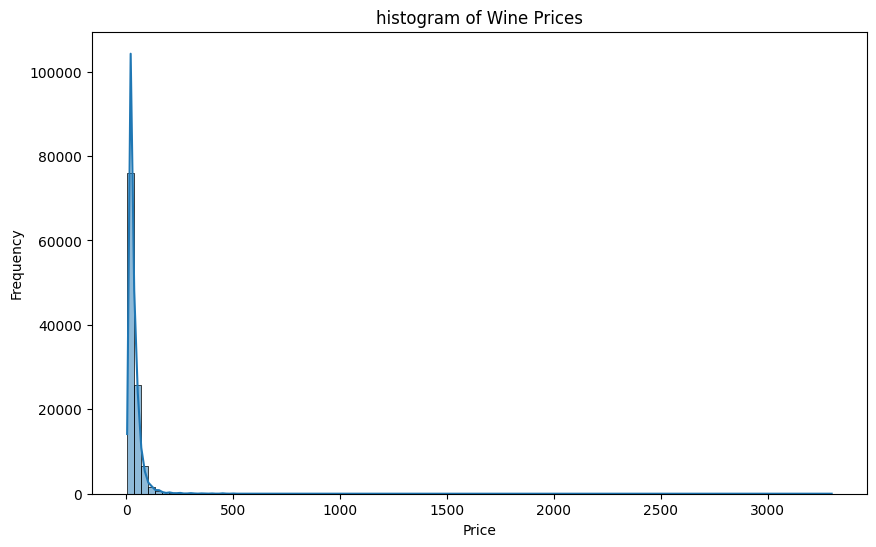

In [212]:
# Create a filtered DataFrame excluding rows where 'price' is 0 for the histogram
df_non_zero_price = df[df['price'] > 0]
df = df_non_zero_price

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('histogram of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()



As we can see, the plot of the price is left-skewed, and we could also observe it by catecorize the wines in a price category

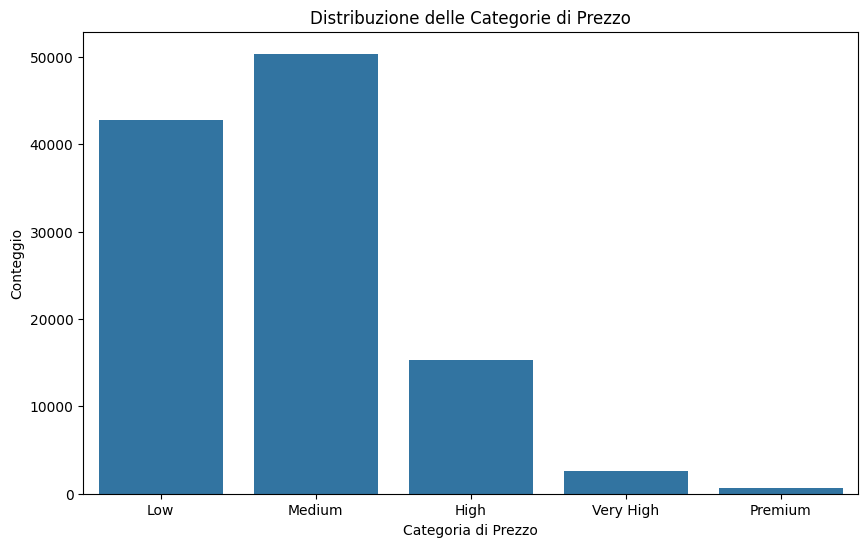

In [230]:
bins = [0, 20, 50, 100, 200, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High', 'Premium']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)

# Creazione della colonna "annata del vino"
df['vintage'] = df['title'].str.extract(r'(\d{4})', expand=False)
df['vintage'] = pd.to_numeric(df['vintage'], errors='coerce')
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='price_category')
plt.title('Distribuzione delle Categorie di Prezzo')
plt.xlabel('Categoria di Prezzo')
plt.ylabel('Conteggio')
plt.show()


## Wine Vintage column

In [214]:
import re
# Function to extract the vintage year from the title or description
def extract_vintage(row):
    # Try to find the year in the title first
    title_match = re.search(r'\b(19|20)\d{2}\b', row['title'])
    if title_match:
        return int(title_match.group(0))
    # If not found in title, try to find the year in the description
    description_match = re.search(r'\b(19|20)\d{2}\b', row['description'])
    if description_match:
        return int(description_match.group(0))
    # If not found in either, return None
    return None

# Apply the function to the dataframe to create the vintage column
df['vintage'] = df.apply(extract_vintage, axis=1)

nan_counts = df.isna().sum()
nan_counts
print("Number of NaN: ", nan_count)

# Converting the vintage column to integer type to remove the .0
df['vintage'] = df['vintage'].astype('Int64')

#new column check
df[['title', 'description', 'vintage']].head()


Number of NaN:  0


,title,description,vintage
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",2011
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",2013
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",2013
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",2012
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Blackberry and raspberry aromas show a typical...,2011


In [215]:
df

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,price_category,vintage
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Low,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Low,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Low,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,High,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,Low,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),Medium,2013
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,High,2004
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,Medium,2013
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,Medium,2012


# Data Exploration

 Analysis and visualisation of our data 

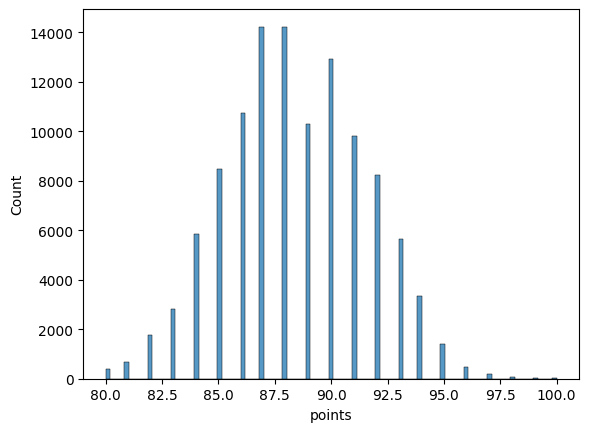

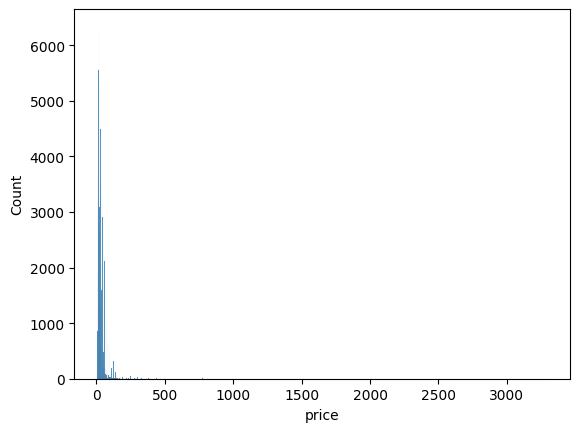

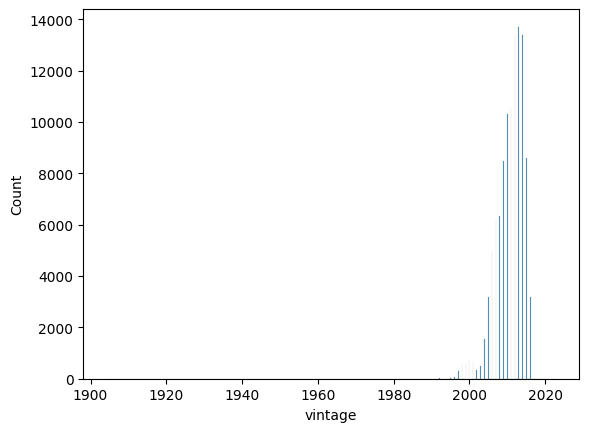

In [216]:
for i in df.select_dtypes(include="number").columns:
    sns.histplot(data=df, x=i)
    plt.show()

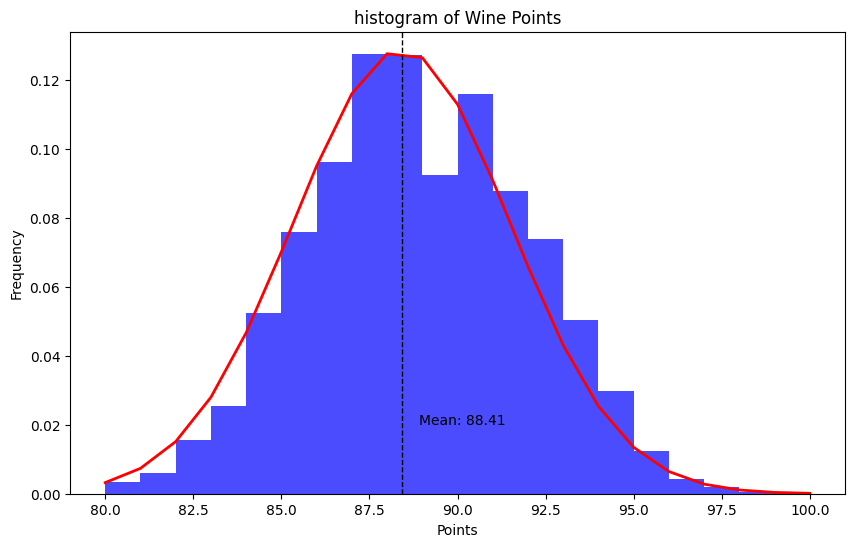

In [217]:
# Histogram of Wine Points
# Assuming 'points' is your column of interest
mean_points = df['points'].mean()
std_points = df['points'].std()

# Generate values for the normal distribution curve
normal_dist = stats.norm.pdf(sorted(df['points']), mean_points, std_points)

plt.figure(figsize=(10, 6))
plt.hist(df['points'], bins=20, density=True, color='blue', alpha=0.7)
plt.plot(sorted(df['points']), normal_dist, color='red', linewidth=2)
plt.title('histogram of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.axvline(mean_points, color='k', linestyle='dashed', linewidth=1)
plt.text(mean_points + 0.5, 0.02, f'Mean: {mean_points:.2f}', rotation=0)
plt.show()



In [218]:
import plotly.express as px
# Ensure the country data is clean
df['country'] = df['country'].fillna('Unknown')

# Count the number of wines per country
country_wine_counts = df['country'].value_counts().reset_index()
country_wine_counts.columns = ['country', 'count']

# Generate the world map
fig = px.choropleth(country_wine_counts,
                    locations="country",
                    locationmode='country names',
                    color="count",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="World Wine Distribution")
fig.update_layout(width=1200, height=600)
fig.show()

# Hypotesis testing

## state of three hypotesis testing:
1 - Null Hypothesis (H0): There is no difference in the average price of red wines and white wines.
    Alternative Hypothesis (H1): There is a significant difference in the average price of red wines compared to white wines.

2 - Null Hypothesis (H0): The mean rating of wines from 2000 onwards is equal to or less than the mean rating of wines produced before 2000.
    Alternative Hypothesis (H1): The mean rating of wines from 2000 onwards is higher than the mean rating of wines produced before 2000.

3 - Null hypothesis (H0): There is no difference in average points between wines from Italy and France.
    Alternative hypothesis (H1): There is a difference in average points between wines from Italy and France. 

In [219]:
# 3
italy_points = df[df['country'] == 'Italy']['points']
france_points = df[df['country'] == 'France']['points']

# Perform t-test
t_stat, p_value = ttest_ind(italy_points.dropna(), france_points.dropna())
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -3.536693724806343, P-value: 0.0004057458126417761


# Confidence Intervals

In [220]:
# Calculate mean and standard error
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')

95% Confidence Interval for the Mean Points of Wines: (88.395787387885, 88.43214984832157)


In [221]:
# Calculate mean and standard error
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval}')

95% Confidence Interval for the Mean Price of Wines: (35.373713875399396, 35.86777976667492)


# Linear Regression and correlation analysis

## Scatterplots and Correlation

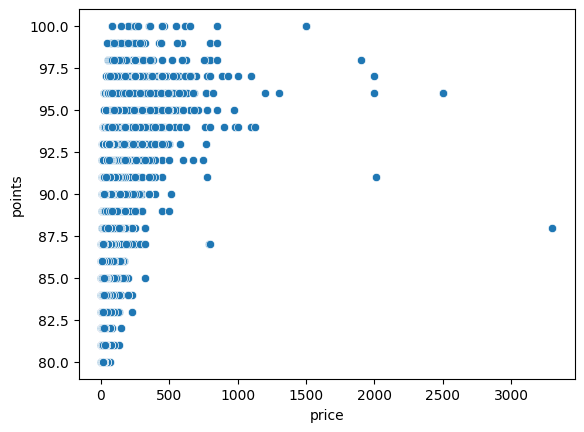

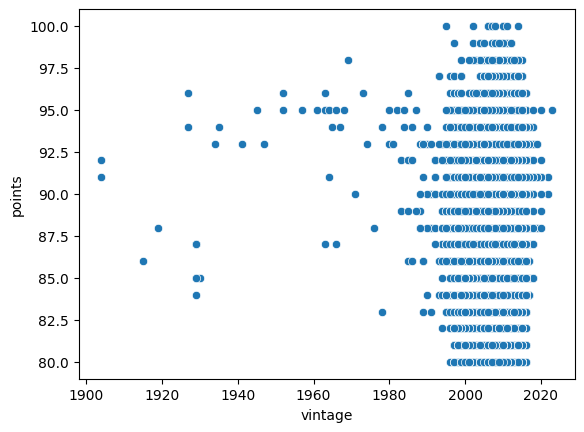

In [222]:
for i in ['price', 'vintage']:
    sns.scatterplot(data=df, x=i, y="points")
    plt.show()


<Figure size 1200x800 with 0 Axes>

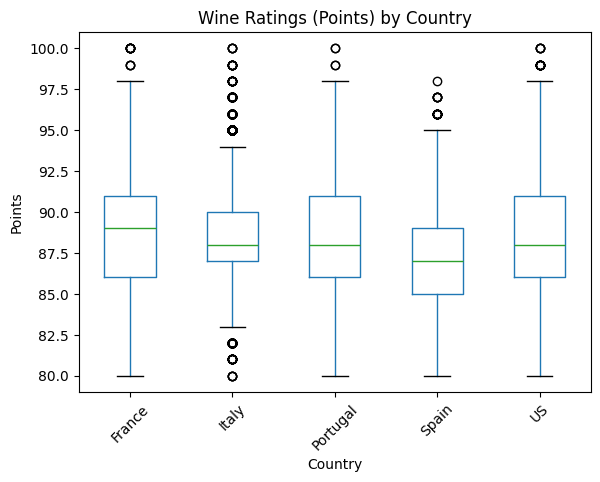

In [223]:
# Select top 10 countries by the number of wine reviews
top_countries = df['country'].value_counts().head(5).index
top_countries_data = df[df['country'].isin(top_countries)]

# Box plot for points by country
plt.figure(figsize=(12, 8))
top_countries_data.boxplot(column='points', by='country', grid=False)
plt.title('Wine Ratings (Points) by Country')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

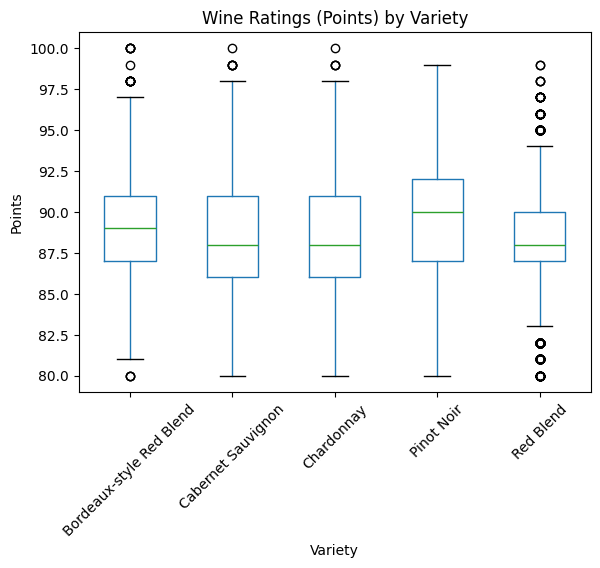

In [224]:
# Select top 10 varieties by the number of wine reviews
top_varieties = df['variety'].value_counts().head(5).index
top_varieties_data = df[df['variety'].isin(top_varieties)]

# Box plot for points by variety
plt.figure(figsize=(12, 8))
top_varieties_data.boxplot(column='points', by='variety', grid=False)
plt.title('Wine Ratings (Points) by Variety')
plt.suptitle('')
plt.xlabel('Variety')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

Index(['points', 'price', 'vintage', 'country_France', 'country_Italy',
       'country_Portugal', 'country_Spain', 'country_US',
       'variety_Bordeaux-style Red Blend', 'variety_Cabernet Sauvignon',
       'variety_Chardonnay', 'variety_Pinot Noir', 'variety_Red Blend'],
      dtype='object')
points                                int64
price                               float64
vintage                               Int64
country_France                         bool
country_Italy                          bool
country_Portugal                       bool
country_Spain                          bool
country_US                             bool
variety_Bordeaux-style Red Blend       bool
variety_Cabernet Sauvignon             bool
variety_Chardonnay                     bool
variety_Pinot Noir                     bool
variety_Red Blend                      bool
dtype: object


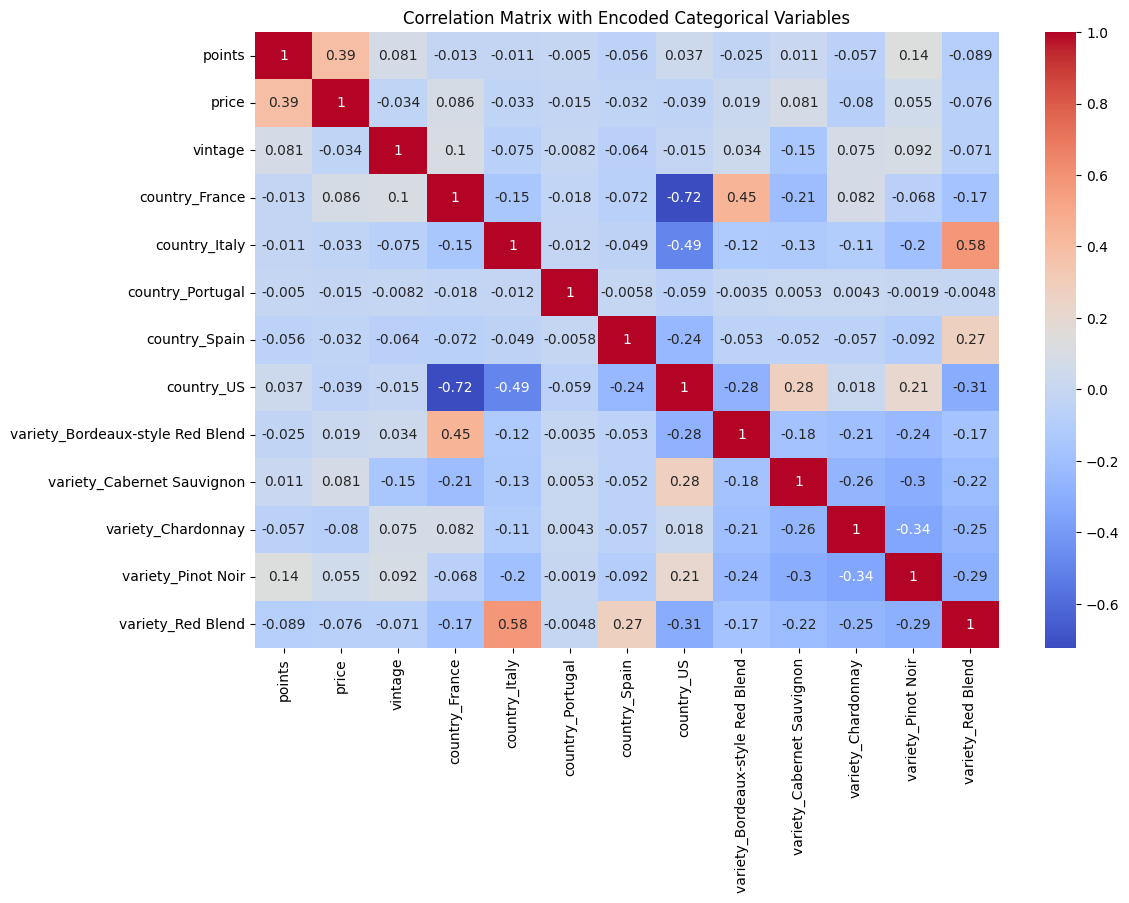

In [225]:
filtered_df = df[df['country'].isin(top_countries) & df['variety'].isin(top_varieties)]
columns_to_drop = ['description', 'designation', 'region_1', 'province', 'region_2', 'title', 'winery', 'price_category']
filtered_df = filtered_df.drop(columns=columns_to_drop)

numerical_columns = ['price', 'points']
categorical_columns = ['country', 'variety']


# Se desideri calcolare la matrice di correlazione includendo le variabili categoriche,
# potresti voler utilizzare la codifica one-hot per le variabili categoriche

# Creazione di un dataframe codificato
encoded_df = pd.get_dummies(filtered_df, columns=categorical_columns)

# Verifica delle colonne codificate e dei loro tipi di dati
print(encoded_df.columns)
print(encoded_df.dtypes)

# Assicurarsi che tutte le colonne siano numeriche
encoded_df = encoded_df.apply(pd.to_numeric, errors='coerce')

# Calcolare la matrice di correlazione per il dataframe codificato
encoded_correlation_matrix = encoded_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(encoded_correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Encoded Categorical Variables')
plt.show()

## Simple Linear Regression 


predict that the country is Italy using the variety Red Blend

price = b_0 + b_1 * points


In [226]:
y = df['price']
x1 = df['points']

# Calcolo delle statistiche necessarie
my = y.mean()
sy = y.std()
n = len(y)
mx1 = x1.mean()
sx1 = x1.std()

# Calcolo del coefficiente di correlazione
num1 = ((x1 - mx1) * (y - my)).sum() / (n - 1)
den1 = sx1 * sy
R_variety = num1 / den1

print("Linear correlation coefficient between Price and Points = ", R_variety)

Linear correlation coefficient between Price and Points =  0.41653398334645414


In [227]:
x_name = 'points'
x = df[x_name].copy()
mx = x.mean()
sx = x.std()
R = encoded_correlation_matrix.loc[x_name, 'price']
b1 = sy/sx*R
b0 = my-b1*mx
n = 42  
# print(f" {'Hello'} {n} ")
print(f"Price = {b0} + {b1} * Points \nR^2 = {R**2}")

Price = -433.45448847402463 + 5.3054425972121315 * Points 
R^2 = 0.1524684615659721


In [228]:
import statsmodels.api as sm
x = df[[x_name]].copy() # in statsmodel the intercept is modeled by adding a constant explanatory variable
x['intercept'] = 1
mod = sm.OLS(y, x) #OLS stands for ordinary least squares

fitted_mod = mod.fit()
print(fitted_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                 2.343e+04
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        18:24:44   Log-Likelihood:            -5.6508e+05
No. Observations:              111593   AIC:                         1.130e+06
Df Residuals:                  111591   BIC:                         1.130e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
points         5.6596      0.037    153.054      0.0

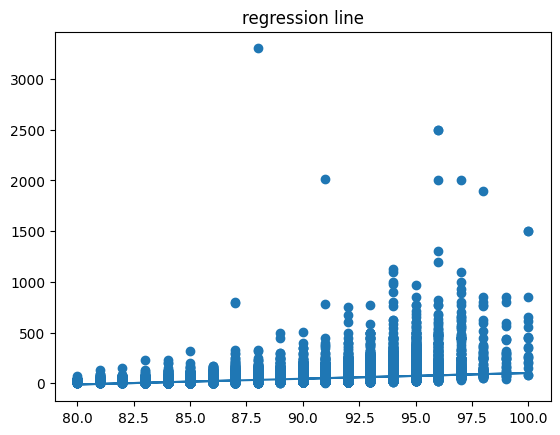

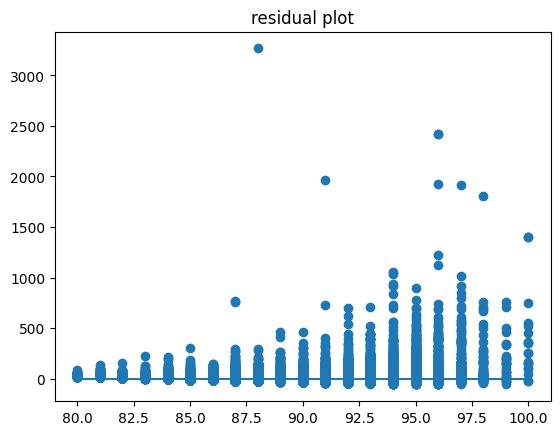

In [229]:
predictions = fitted_mod.predict(x)
plt.scatter(x = x['points'],y = y)
plt.plot(x['points'],predictions)
plt.title('regression line')
plt.show()

residuals = y-predictions
plt.scatter(x = x['points'],y = residuals)
plt.plot([x['points'].min(), x['points'].max()], [0,0])
plt.title('residual plot')
plt.show()

# Conclusions